# **Semantic Segmentation with CamVid Dataset**

In this notebook, the [SegFormer-B2](https://huggingface.co/nvidia/mit-b2) model is fine-tuned using the [Cambridge-driving Labeled Video Database (CamVid)](https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) dataset for semantic segmentation tasks.  

The [SegFormer](https://arxiv.org/pdf/2105.15203) model is an innovative approach to segmentation that balances efficiency and accuracy. It consists of two main components:  

1. **Hierarchical Transformer Encoder (MiT - Mix Transformer):** This encoder features a hierarchical architecture that effectively captures both global and local image information. It has been pretrained on the [ImageNet-1k](https://www.image-net.org/download.php) dataset, providing robust visual feature representations.  

2. **Lightweight MLP-based Decoder Head:** Designed for efficiency, this decoder translates the features extracted by the encoder into detailed segmentation maps. Specifically, the *nvidia/segformer-b2-finetuned-cityscapes-1024-1024* model has been fine-tuned on the [Cityscapes](https://www.cityscapes-dataset.com/) dataset, which is more challenging, robust, and large-scale compared to CamVid. Cityscapes contains a diverse set of stereo video sequences recorded in street scenes across 50 different cities, making it a strong foundation for fine-tuning models on small datasets like CamVid.  

*SegFormer Model Architecture:*

![SegFormer](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/segformer_architecture.png)

The **CamVid** dataset consists of 701 frames, each with a resolution of 720 × 960 pixels, extracted from five video sequences recorded using fixed-position CCTV cameras mounted on a vehicle. Initially, the segmentation masks contained 32 classes, but they were later merged into 11 main categories (12 including the `void` class).  

The dataset does not have an official split; therefore, most studies use a partition of 367 images for training, 101 for validation, and 233 for testing. However, due to its small size, in this case, all 701 images and their corresponding masks are divided into 80% for training and 20% for validation to enhance the model's performance in segmentation tasks.  

## **Imports**

In [1]:
# Install the latest version of the Transformers library that is compatible with Colab's TPU
!pip install transformers==4.44.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.3 MB/s eta 0:00:00


In [ ]:
#!pip install tensorflow==2.17.0 -q #(TPU version)

In [1]:
import tensorflow as tf
from transformers import AutoImageProcessor, TFAutoModelForSemanticSegmentation, create_optimizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from google.colab import drive
from glob import glob
from tqdm.auto import tqdm
import cv2
import os

# Suppress AutoGraph warnings caused by the Transformers library
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(0)

## **Parameters**

In [2]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
model_name = "nvidia/segformer-b2-finetuned-cityscapes-1024-1024"
checkpoint_folder = "/content/drive/MyDrive/checkpoints/SemanticSegmentation_SegFormer-B2_CamVid"
trained_model_path = "/content/drive/MyDrive/models/SemanticSegmentation_SegFormer-B2_CamVid"
zip_dataset_path = "/content/drive/MyDrive/Datasets/CamVid.zip"
dataset_dir = os.path.basename(zip_dataset_path).split(".")[0]
epochs = 100
batch_size = 8
patience = 7
save_freq = 25
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
buffer_size = 128

## **Prepare the Dataset for Training**

### **Load the Dataset**

The download and all preliminary preprocessing of the CamVid dataset were completed in the following notebook: [Preprocessing_CamVid](https://github.com/JersonGB22/ImageSegmentation-TensorFlow-PyTorch/blob/main/Preprocessing/Preprocessing_CamVid.ipynb).

In [4]:
# Unzip the dataset
!unzip -q $zip_dataset_path

In [63]:
# Obtain the training and validation DataFrames
df_data = pd.read_csv(os.path.join(dataset_dir, "metadata.csv"))
df_train = df_data[df_data.split == "train"]
df_val = df_data[df_data.split == "val"]

print(len(df_train), len(df_val))
df_data

560 141


image_path  \
0      /content/CamVid/images/0016E5_05880.png   
1      /content/CamVid/images/0016E5_01200.png   
2      /content/CamVid/images/0016E5_05520.png   
3    /content/CamVid/images/Seq05VD_f01020.png   
4      /content/CamVid/images/0016E5_08115.png   
..                                         ...   
696   /content/CamVid/images/0006R0_f01740.png   
697    /content/CamVid/images/0016E5_02100.png   
698   /content/CamVid/images/0001TP_007620.png   
699    /content/CamVid/images/0016E5_04800.png   
700    /content/CamVid/images/0016E5_08340.png   

                                      mask_path  split  
0      /content/CamVid/masks/0016E5_05880_L.png  train  
1      /content/CamVid/masks/0016E5_01200_L.png  train  
2      /content/CamVid/masks/0016E5_05520_L.png  train  
3    /content/CamVid/masks/Seq05VD_f01020_L.png  train  
4      /content/CamVid/masks/0016E5_08115_L.png  train  
..                                          ...    ...  
696   /content/CamVid/masks/0006R0_f01740_L.png    val  
697    /content/CamVid/masks/0016E5_02100_L.png    val  
698   /content/CamVid/masks/0001TP_007620_L.png    val  
699    /content/CamVid/masks/0016E5_04800_L.png    val  
700    /content/CamVid/masks/0016E5_08340_L.png    val  

[701 rows x 3 columns]

In [6]:
# Load the classes DataFrame
df_classes = pd.read_csv(os.path.join(dataset_dir, "classes.csv"))
df_classes["color"] = df_classes.color.apply(lambda x: eval(x))

class_names = df_classes.name.values.tolist()
class_colors = np.array(df_classes.color.values.tolist())
num_classes = len(class_names)
background_class = ignore_class = class_names.index("void")

df_classes

name            color
0         void        [0, 0, 0]
1          sky  [128, 128, 128]
2     building      [128, 0, 0]
3         pole  [192, 192, 128]
4         road   [128, 64, 128]
5     sidewalk      [0, 0, 192]
6         tree    [128, 128, 0]
7   signsymbol  [192, 128, 128]
8        fence    [64, 64, 128]
9          car     [64, 0, 128]
10  pedestrian      [64, 64, 0]
11   bicyclist    [0, 128, 192]

### **Data Augmentation**

Data augmentation is crucial for improving a model's performance and combating overfitting. However, unfortunately, TensorFlow does not provide specific functions or layers for data augmentation in semantic segmentation tasks, so they must be implemented manually.

In [8]:
# Download the image and mask processor for the segmentation model
image_processor = AutoImageProcessor.from_pretrained(model_name)
image_processor

SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

Although the processor has a default size of (512, 512, 3) for images and segmentation masks, a size of (1024, 1024, 3) is used, which helps achieve slightly better results.

In [9]:
# Set image size, mean, and standard deviation for normalization
image_size = (1024, 1024, 3) #(image_processor.size["height"], image_processor.size["width"], 3)
image_mean = tf.constant(image_processor.image_mean)
image_std = tf.constant(image_processor.image_std)

In [10]:
# Function for performing random horizontal flipping of the image and its mask
@tf.function
def random_flip_left_right(image, mask, p=0.5):
  if tf.random.uniform(()) > (1 - p):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  return image, mask


# Function to randomly scale an image and its mask using cropping or padding
@tf.function
def random_scale(image, mask, scale=(0.8, 1.2), p=0.5):
  if tf.random.uniform(()) > (1 - p):
    height, width = tf.shape(image)[0], tf.shape(image)[1]

    scale_factor = tf.random.uniform((), scale[0], scale[1])
    scaled_height = tf.cast(tf.cast(height, tf.float32) * scale_factor, tf.int32)
    scaled_width = tf.cast(tf.cast(width, tf.float32) * scale_factor, tf.int32)

    image = tf.image.resize(image, (scaled_height, scaled_width))
    mask = tf.image.resize(mask, (scaled_height, scaled_width), method="nearest")

    image = tf.image.resize_with_crop_or_pad(image, height, width)
    mask = tf.image.resize_with_crop_or_pad(mask, height, width)

    image = tf.ensure_shape(image, image_size)
    mask = tf.ensure_shape(mask, image_size[:-1] + (1,))

  return image, mask


# Function for randomly altering the brightness and contrast of the image
@tf.function
def random_brightness_contrast(image, brightness_limit=0.2, contrast_limit=0.3, p=0.5):
  if tf.random.uniform(()) > (1 - p):
    image = tf.image.random_brightness(image, brightness_limit)
    image = tf.image.random_contrast(image, 1 - contrast_limit, 1 + contrast_limit)
  return image

In [11]:
# Function for data augmentation
def data_augmentation(image, mask):
  image, mask = random_flip_left_right(image, mask)
  image, mask = random_scale(image, mask, scale=(1.0, 1.3), p=0.6)
  image = random_brightness_contrast(image)

  return image, mask

### **Create the Training, Validation and Test datasets**

In [12]:
# Function to preprocess an image and its mask
@tf.function
def preprocessing(image_path, mask_path, image_size=image_size[:-1]):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, image_size)

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, image_size, method="nearest")

  return image, mask


# Function to normalize image and mask
@tf.function
def normalization(image, mask):
  image = ((image / 255) - image_mean) / image_std
  image = tf.transpose(image, [2, 0, 1])
  mask = tf.squeeze(mask)
  return image, mask


# Function to convert the DataFrame into a Dataset for training or evaluation
def prepare_dataset(df, train=True, drop_remainder=True):
  dataset = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["mask_path"].values))
  dataset = dataset.map(preprocessing, num_parallel_calls=AUTOTUNE)

  if train:
    dataset = dataset.map(data_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(buffer_size, seed=SEED)

  dataset = (
      dataset.
      map(normalization, num_parallel_calls=AUTOTUNE).
      batch(batch_size, drop_remainder=drop_remainder).
      prefetch(AUTOTUNE)
  )

  return dataset

In the Google Colab TPU environment, when using custom loss functions to train a model, it is necessary for all batches to have the same size. Otherwise, the loss at the end of the first epoch will return a **NaN** value. Therefore, the `drop_remainder` parameter should be set to **True** to discard the last batch of a dataset. Additionally, it is important to choose a batch size that removes the least amount of data from the last batch to minimize the impact on training.  

On the other hand, during model evaluation, the complete dataset should be used with `drop_remainder` set to **False**. Although if a batch size is chosen that removes very few data, the evaluation results will vary slightly, being virtually the same, but it is a good practice to set `drop_remainder` to **False** during evaluation to obtain exact results.

In [13]:
# Number of records deleted
len(df_train) % batch_size, len(df_val) % batch_size

(0, 5)

In [81]:
train_dataset = prepare_dataset(df_train)
val_dataset = prepare_dataset(df_val, train=False)

In [82]:
# Take a batch from the training dataset
for images, masks in train_dataset.take(1):
  print(images.shape)
  print(masks.shape)

(8, 3, 1024, 1024)
(8, 1024, 1024)


In [83]:
# Function to plot images with their segmentation masks
def plot_image_masks(images, masks, masks_pred=None, n_rows=3, random=True, blended=False,
                     alpha=0.6, metric=None, preprocess=False, save=False, path_save=""):

  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  n_cols = 2 if masks_pred is None else 3
  titles = ["Image", "True Mask"] + ([] if masks_pred is None else ["Pred Mask"])

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.25 * n_cols, 3.25 * n_rows))
  for col, title in enumerate(titles):
    axes[0, col].set_title(title, fontsize=10)

  for i in range(n_rows):
    idx = indices[i]
    image = tf.transpose(images[idx], [1, 2, 0])
    image = np.clip((image * image_std) + image_mean, 0, 1)
    mask_cls = masks[idx]
    mask_rgb = class_colors[mask_cls] / 255
    shape = image.shape

    if blended:
      mask_rgb = mask_rgb.astype(image.dtype)
      mask_rgb[mask_cls == background_class] = image[mask_cls == background_class]
      mask_rgb = cv2.addWeighted(image, 1 - alpha, mask_rgb, alpha, 0)

    axes[i, 0].imshow(image)
    axes[i, 0].axis("off")
    axes[i, 1].imshow(mask_rgb)
    axes[i, 1].axis("off")

    if masks_pred is not None:
      mask_cls_pred = masks_pred[idx]
      mask_cls_pred[mask_cls == ignore_class] = ignore_class
      mask_rgb_pred = class_colors[mask_cls_pred] / 255

      if blended:
        mask_rgb_pred = mask_rgb_pred.astype(image.dtype)
        mask_rgb_pred[mask_cls_pred == background_class] = image[mask_cls_pred == background_class]
        mask_rgb_pred = cv2.addWeighted(image, 1 - alpha, mask_rgb_pred, alpha, 0)

      axes[i, 2].imshow(mask_rgb_pred)
      axes[i, 2].axis("off")

      if metric is not None:
        metric.reset_state()
        metric.update_state(mask_cls, mask_cls_pred, preprocess=preprocess)

        axes[i, 2].text(
          x=shape[1]/2, y=shape[0],
          s=f"{metric.metric_name.replace('_', ' ')}: {metric.result():.3f}",
          fontsize=7, ha="center", va="top",
        )

  plt.tight_layout()
  # Save images
  if save:
    plt.savefig(path_save)

  plt.show()

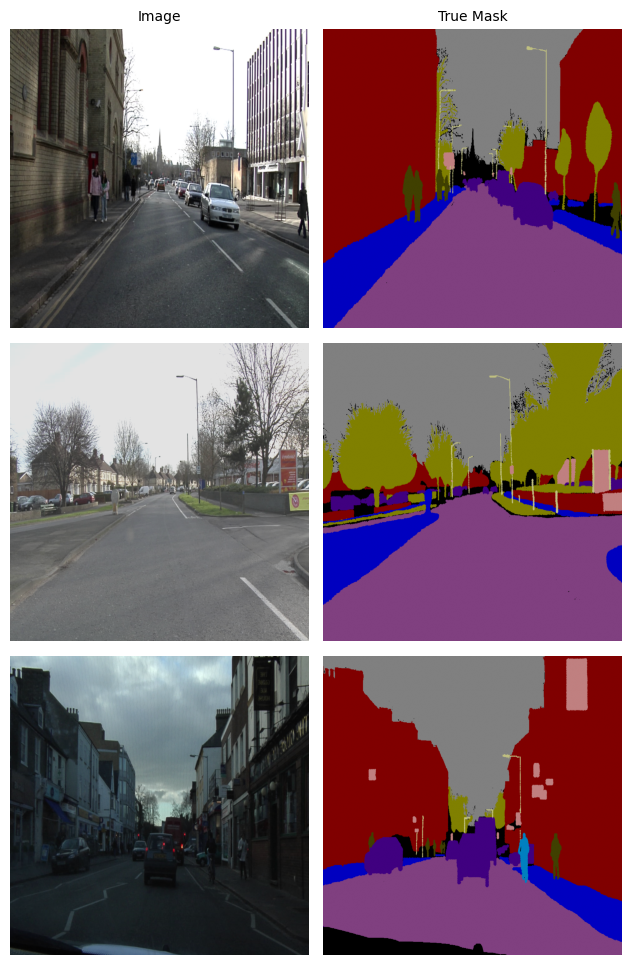

In [84]:
# Some images and masks from the training dataset after data augmentation
plot_image_masks(images, masks)

## **Build and Compile the Model**

### **Create the Segmentation Metrics and Loss**

In image semantic segmentation, the most commonly used metrics to evaluate model performance are **Mean IoU** and **Dice Score**.  

1. **Mean IoU:** Mean IoU (Intersection over Union) measures the overlap between the predicted areas and the ground truth areas for each class and averages the results across all classes. It is a standard metric in semantic segmentation. Its general formula for the multiclass case is:  
   $$
   Mean\ IoU = \frac{1}{C} \sum_{c=1}^C \frac{|P_c \cap T_c|}{|P_c \cup T_c|}
   $$
   Where:  
   - $C$ is the number of classes.  
   - $P_c$ and $T_c$ represent the predicted areas and the ground truth areas for class $c$.  
   - $|P_c \cap T_c|$ is the intersection area between the prediction and the ground truth.  
   - $|P_c \cup T_c|$ is the union area between the prediction and the ground truth.  

2. **Dice Score:** Dice Score (or Dice Coefficient) is another common metric that measures the similarity between predicted and true areas. It is particularly useful for imbalanced datasets. Its general formula for the multiclass case is:  
   $$
   Dice\ Score = \frac{1}{C} \sum_{c=1}^C \frac{2 |P_c \cap T_c|}{|P_c| + |T_c|}
   $$
   The terms are the same as in Mean IoU, but Dice Score is more sensitive to small differences between the prediction and the ground truth.  

A custom class implemented in TensorFlow is introduced below to calculate these metrics, designed to work for both binary and multiclass segmentation. Key features of this class include:  

- **Support for ignored classes:** Certain classes, such as the background or unlabeled regions, can be excluded from metric calculations. This is the case with the CamVid dataset, where the `void` class is ignored in the computation.
 
- **Handling of missing classes:** If one or more classes are absent in both the ground truth and predicted masks, the metric returns a NaN value for those classes, ensuring they are excluded from the final calculation. This is particularly useful in multi-class segmentation tasks, where individual masks or batches may not include all classes from a specific dataset, as is the case with LandCover.ai and CamVid.

In [15]:
# Custom class to calculate Mean IoU or Dice Score
@tf.keras.utils.register_keras_serializable()
class SegmentationMetrics(tf.keras.metrics.Metric):
  def __init__(self, metric_name, num_classes, image_size, ignore_class=None, **kwargs):

    if metric_name not in {"mean_iou", "dice_score"}:
      raise ValueError("Invalid metric. Choose 'mean_iou' or 'dice_score'.")

    super().__init__(name=metric_name, **kwargs)
    self.metric_name = metric_name
    self.num_classes = num_classes
    self.image_size = image_size
    self.ignore_class = ignore_class

    # Initialize tensors to store cumulative intersection and combined areas
    self.intersect_area_total = self.add_weight(name="intersect_area", shape=(num_classes,), initializer="zeros")
    self.combined_area_total = self.add_weight(name="combined_area", shape=(num_classes,), initializer="zeros")

  def update_state(self, y_true, y_pred, preprocess=True, sample_weight=None):
    # Convert logits to class predictions if preprocessing is enabled
    if preprocess:
      y_pred = tf.transpose(y_pred, [0, 2, 3, 1])
      y_pred = tf.image.resize(y_pred, self.image_size[:-1])
      y_pred = tf.argmax(y_pred, axis=-1)

    # Flatten predictions and labels
    y_true = tf.reshape(tf.cast(y_true, tf.int32), (-1,))
    y_pred = tf.reshape(tf.cast(y_pred, tf.int32), (-1,))

    # Apply mask to ignore specific class, if configured
    if self.ignore_class is not None:
      mask = tf.not_equal(y_true, self.ignore_class)
      y_true = tf.boolean_mask(y_true, mask)
      y_pred = tf.boolean_mask(y_pred, mask)

    # Convert to one-hot encoding for multiclass processing
    y_true = tf.one_hot(y_true, depth=self.num_classes)
    y_pred = tf.one_hot(y_pred, depth=self.num_classes)

    # Calculate intersection and combined areas
    intersect_area = tf.reduce_sum(y_true * y_pred, axis=0)
    combined_area = tf.reduce_sum(y_true + y_pred, axis=0)

    # Update cumulative totals
    self.intersect_area_total.assign_add(intersect_area)
    self.combined_area_total.assign_add(combined_area)

  # Compute metric for each class
  def result_by_class(self):
    if self.metric_name == "mean_iou":
      union_area_total = self.combined_area_total - self.intersect_area_total
      metric = tf.math.divide_no_nan(self.intersect_area_total, union_area_total)
    else:
      metric = tf.math.divide_no_nan(2 * self.intersect_area_total, self.combined_area_total)

    # Assign NaN to classes with no samples
    metric = tf.where(self.combined_area_total > 0, metric, tf.constant(float("nan"), dtype=metric.dtype))
    return metric

  # Calculate average metric across valid classes
  def result(self):
    metric = self.result_by_class()
    metric = tf.boolean_mask(metric, tf.logical_not(tf.math.is_nan(metric)))
    return tf.reduce_mean(metric)

  # Reset accumulated values
  def reset_state(self):
    self.intersect_area_total.assign(tf.zeros_like(self.intersect_area_total))
    self.combined_area_total.assign(tf.zeros_like(self.combined_area_total))

  # Returns the configuration of the metric as a dictionary for serialization
  def get_config(self):
    return {
        "metric_name": self.metric_name,
        "num_classes": self.num_classes,
        "image_size": self.image_size,
        "ignore_class": self.ignore_class
    }


# Custom function to calculate Accuracy with the option to ignore a class
@tf.keras.utils.register_keras_serializable()
def compute_accuracy(image_size, ignore_class=None):
  def accuracy(y_true, y_pred):
    y_pred = tf.transpose(y_pred, [0, 2, 3, 1])
    y_pred = tf.image.resize(y_pred, image_size[:-1])
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), y_true.dtype)

    true_positives = tf.cast(y_true == y_pred, tf.float32)

    if ignore_class is not None:
      mask = tf.cast(y_true != ignore_class, tf.float32)
      acc = tf.reduce_sum(true_positives * mask) / tf.reduce_sum(mask)
    else:
      acc = tf.reduce_mean(true_positives)

    return acc
  return accuracy

A custom loss class is implemented that combines **Cross-Entropy loss** and **Dice loss ($1 - Dice\ Score$)**. Cross-entropy measures pixel-level similarity between predicted and ground truth masks, while Dice loss ensures precise boundary localization. This combination is effective for achieving both accurate segmentation and high overall precision in semantic segmentation tasks.  

Additionally, the custom loss allows for ignoring specific classes, which is useful in datasets where certain classes, such as **background** or **unlabeled** regions, are discarded. This is the case with **CamVid**, where the `void` class is excluded. It also supports scenarios where not all dataset classes are present in a segmentation mask batch, as seen in **CamVid**.  

Lastly, the custom loss function provides the option to assign specific weights to certain classes, which is particularly beneficial for imbalanced segmentation datasets. This helps mitigate class imbalance and improve overall model performance.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class CrossEntropyDiceLoss(tf.keras.losses.Loss):
  def __init__(self, num_classes, image_size, ignore_class=None, class_weight=None, from_logits=False, name="crossentropy_dice_loss"):
    super().__init__(name=name)
    self.num_classes = num_classes
    self.image_size = image_size
    self.ignore_class = ignore_class
    self.class_weight = class_weight if class_weight is None else tf.constant(class_weight, tf.float32)
    self.from_logits = from_logits
    self.name = name
    self.scce_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction="none")

  def compute_dice_loss(self, y_true, y_pred):
    # Convert ground truth to one-hot encoding
    y_true_ohe = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)

    # Apply mask to ignore specific class, if configured
    if self.ignore_class is not None:
      mask = tf.cast(y_true != self.ignore_class, tf.float32)[..., None]
      y_true_ohe *= mask
      y_pred *= mask

    # Calculate the areas and Dice loss
    intersect_area = tf.reduce_sum(y_true_ohe * y_pred, axis=[0, 1, 2])
    combined_area = tf.reduce_sum(y_true_ohe + y_pred, axis=[0, 1, 2])
    loss = 1 - tf.math.divide_no_nan(2 * intersect_area, combined_area)
    
    # Apply class weights if configured
    if self.class_weight is not None:
      loss *= self.class_weight

    # Discard the absent classes and calculate the average loss
    mask = tf.reduce_sum(y_true_ohe, axis=[0, 1, 2]) > 0
    loss = tf.boolean_mask(loss, mask)
    loss = tf.reduce_mean(loss)

    return loss

  def compute_crossentropy_loss(self, y_true, y_pred):
    # Apply class weights if provided
    if self.class_weight is not None:
      sample_weight = tf.gather(self.class_weight, indices=tf.cast(y_true, tf.int32))
    else:
      sample_weight = None
    
    # Calculate the Cross-Entropy loss
    loss = self.scce_fn(y_true, y_pred, sample_weight=sample_weight)

    # Apply mask to ignore specific class, if configured, and calculate the average Cross-Entropy loss
    if self.ignore_class is not None:
      mask = tf.cast(y_true != self.ignore_class, tf.float32)
      loss = tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)
    else:
      loss = tf.reduce_mean(loss)

    return loss

  def call(self, y_true, y_pred):
    # Preprocess the predicted masks
    y_pred = tf.transpose(y_pred, [0, 2, 3, 1])
    y_pred = tf.image.resize(y_pred, self.image_size[:-1])

    # Apply softmax to predicted logits, if configured
    if self.from_logits:
      y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Compute Cross-Entropy loss and Dice loss
    scce_loss = self.compute_crossentropy_loss(y_true, y_pred)
    dice_loss = self.compute_dice_loss(y_true, y_pred)

    # Calculate the overall loss
    loss = scce_loss + dice_loss
    return loss

  # Returns the configuration of the loss as a dictionary for serialization
  def get_config(self):
    return {
        "num_classes": self.num_classes,
        "image_size": self.image_size,
        "ignore_class": self.ignore_class,
        "class_weight": self.class_weight if self.class_weight is None else self.class_weight.numpy(),
        "from_logits": self.from_logits,
        "name": self.name
    }

### **TPU Initialization and Model Compilation**

In [16]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except (ValueError, tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as error:
  print(f"Error: {error}")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


Class weights are approximately determined after initially training the model without class weights. Weights are then applied to the classes where the model performs poorly, resulting in a slightly higher Mean IoU for classes with a weight greater than 1.0.

In [ ]:
class_weight = np.array([
    1.0,  #void: The loss ignores this class
    1.0,  #sky
    1.0,  #building
    5.0,  #pole
    1.0,  #road
    1.0,  #sidewalk
    1.0,  #tree
    3.0,  #signsymbol
    1.0,  #fence
    1.0,  #car
    3.0,  #pedestrian
    1.0   #bicyclist
])

In [ ]:
# Compile the model within the TPU strategy
tf.keras.backend.clear_session()

with strategy.scope():
  model = TFAutoModelForSemanticSegmentation.from_pretrained(
      model_name,
      num_labels=num_classes,
      semantic_loss_ignore_index=ignore_class,
      ignore_mismatched_sizes=True
  )

  optimizer, lr_schedule = create_optimizer(
      init_lr=5e-4,
      num_train_steps=len(train_dataset)*epochs,
      num_warmup_steps=0,
      weight_decay_rate=0.01
  )

  model.compile(
      optimizer=optimizer,
      loss=CrossEntropyDiceLoss(num_classes, image_size, ignore_class, class_weight, from_logits=True),
      metrics=[
          compute_accuracy(image_size, ignore_class),
          SegmentationMetrics("mean_iou", num_classes, image_size, ignore_class)
      ]
  )

model.summary()

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head/classifier/kernel:0: found shape (1, 1, 768, 19) in the checkpoint and (1, 1, 768, 12) in the model instantiated
- decode_head/classifier/bias:0: found shape (19,) in the checkpoint and (12,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  24196288  
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  3161100   
 codeHead)                                                       
                                                                 
Total params: 27357388 (104.36 MB)
Trainable params: 27355852 (104.35 MB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


## **Train the Model**

Since the free version of Google Colab has a TPU environment limit of 3 hours and 20 minutes, a custom callback is implemented to save the model, its optimizer, and the training history, which includes the training and validation metrics and losses throughout the epochs. This allows for resuming the training from where it was left off. The total fine-tuning time for the model is approximately 4 hours.

In [ ]:
# Callback to save checkpoints and training history
class CheckpointCallback(tf.keras.callbacks.Callback):
  def __init__(self, checkpoint, path_save, save_freq, history):
    super().__init__()
    self.checkpoint = checkpoint
    self.path_save = path_save
    self.save_freq = save_freq
    self.history = history

  def on_epoch_end(self, epoch, logs=None):
    epoch_history = pd.DataFrame({k: [v] for k, v in logs.items()})
    self.history = pd.concat([self.history, epoch_history], axis=0, ignore_index=True)
    self.history.to_csv(os.path.join(self.path_save, "history.csv"), index=False)

    if (epoch + 1) % self.save_freq == 0:
      self.checkpoint.save(file_prefix=os.path.join(self.path_save, f"epoch_{epoch + 1}"))

In [ ]:
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
pretrained = True #Change according to previous training

if pretrained:
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_folder))
  history = pd.read_csv(os.path.join(checkpoint_folder, "history.csv"))
  initial_epoch = len(history)

else:
  os.makedirs(checkpoint_folder, exist_ok=True)
  history = pd.DataFrame({
      "loss": [], "val_loss": [],
      "accuracy": [], "val_accuracy": [],
      "mean_iou": [], "val_mean_iou": []
  })
  initial_epoch = 0

In [ ]:
# Instantiate the checkpoint callback
checkpoint_callback = CheckpointCallback(checkpoint, checkpoint_folder, save_freq, history)

# Early stopping callback to monitor validation Mean IoU
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_iou",
    patience=patience,
    mode="max",
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint_callback, early_callback],
    initial_epoch=initial_epoch
)

Epoch 51/100
70/70 [==============================] - 367s 3s/step - loss: 0.2726 - accuracy: 0.9770 - mean_iou: 0.9098 - val_loss: 0.5077 - val_accuracy: 0.9637 - val_mean_iou: 0.8650
Epoch 52/100
70/70 [==============================] - 155s 2s/step - loss: 0.2716 - accuracy: 0.9769 - mean_iou: 0.9098 - val_loss: 0.5018 - val_accuracy: 0.9636 - val_mean_iou: 0.8656
Epoch 53/100
70/70 [==============================] - 152s 2s/step - loss: 0.2699 - accuracy: 0.9770 - mean_iou: 0.9099 - val_loss: 0.5091 - val_accuracy: 0.9624 - val_mean_iou: 0.8641
Epoch 54/100
70/70 [==============================] - 153s 2s/step - loss: 0.2752 - accuracy: 0.9759 - mean_iou: 0.9082 - val_loss: 0.4944 - val_accuracy: 0.9627 - val_mean_iou: 0.8651
Epoch 55/100
70/70 [==============================] - 153s 2s/step - loss: 0.2682 - accuracy: 0.9768 - mean_iou: 0.9101 - val_loss: 0.4986 - val_accuracy: 0.9641 - val_mean_iou: 0.8672
Epoch 56/100
70/70 [==============================] - 153s 2s/step - loss: 

In [ ]:
# Save the model
model.save_pretrained(trained_model_path)

## **Model Evaluation**

In [ ]:
# Evaluation excluding the last batches of the datasets (drop_remainder=True)
metrics_train = model.evaluate(train_dataset, verbose=0)
metrics_val = model.evaluate(val_dataset, verbose=0)

print(f"Train\tLoss: {metrics_train[0]}; Mean IoU: {metrics_train[2]}; Accuracy: {metrics_train[1]}")
print(f"Val\tLoss: {metrics_val[0]}; Mean IoU: {metrics_val[2]}; Accuracy: {metrics_val[1]}")

Train	Loss: 0.21887756884098053; Mean IoU: 0.9248371124267578; Accuracy: 0.980941891670227
Val	Loss: 0.5165019035339355; Mean IoU: 0.8704471588134766; Accuracy: 0.9649304747581482


### **Graphs of the metrics**

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.5 MB/s eta 0:00:00


In [ ]:
# Load the training history
history = pd.read_csv(os.path.join(checkpoint_folder, "history.csv"))

# Delete the checkpoint if it is no longer needed
#!rm -r $checkpoint_folder

In [ ]:
# Function to plot the metrics
def plot_metrics(history, metrics=["loss"], renderer=None):
  epochs = len(history["loss"])
  list_epochs = np.arange(1, epochs + 1)
  patience = history.val_mean_iou.idxmax() + 1

  for metric in metrics:
    values = history[metric]
    val_values = history[f"val_{metric}"]

    fig=go.Figure()
    fig.add_trace(go.Scatter(x=list_epochs, y=values, name=metric, line=dict(color="blue", width=2)))
    fig.add_trace(go.Scatter(x=list_epochs, y=val_values, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

    fig.add_vline(
        x=patience, line=dict(color="red", width=2, dash="dash"),
        annotation_text="End of Training", annotation_position="top left",
        annotation=dict(font_size=12, font_color="red")
    )

    fig.update_xaxes(title_text="Epoch")
    fig.update_yaxes(title_text=metric)
    fig.update_layout(
        title=f"Evolution of {metric} across Epochs",
        title_font=dict(size=20),
        title_x=0.5,
        height=500,
        width=1200
    )

    fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(history, metrics=["loss", "accuracy", "mean_iou"])

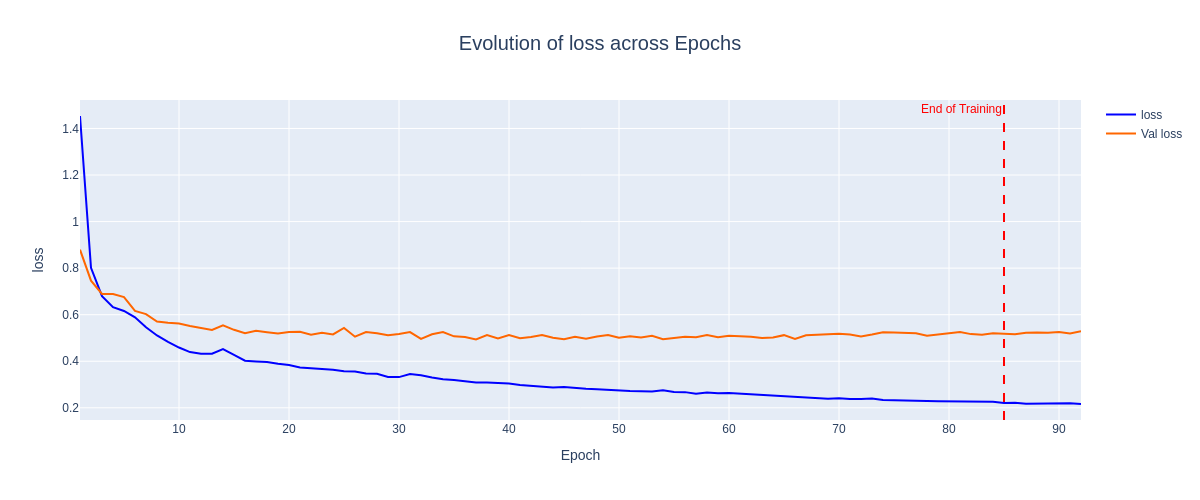

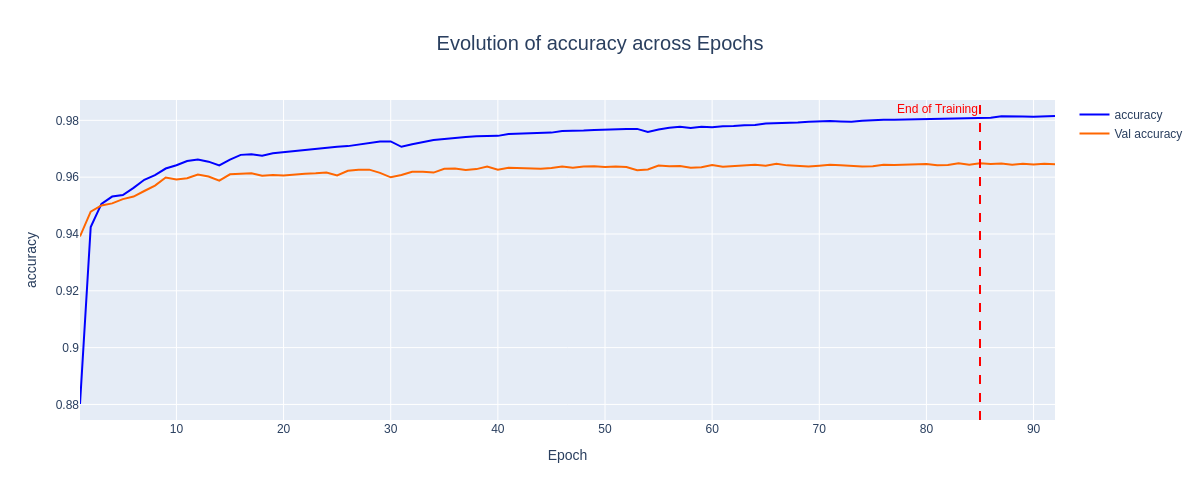

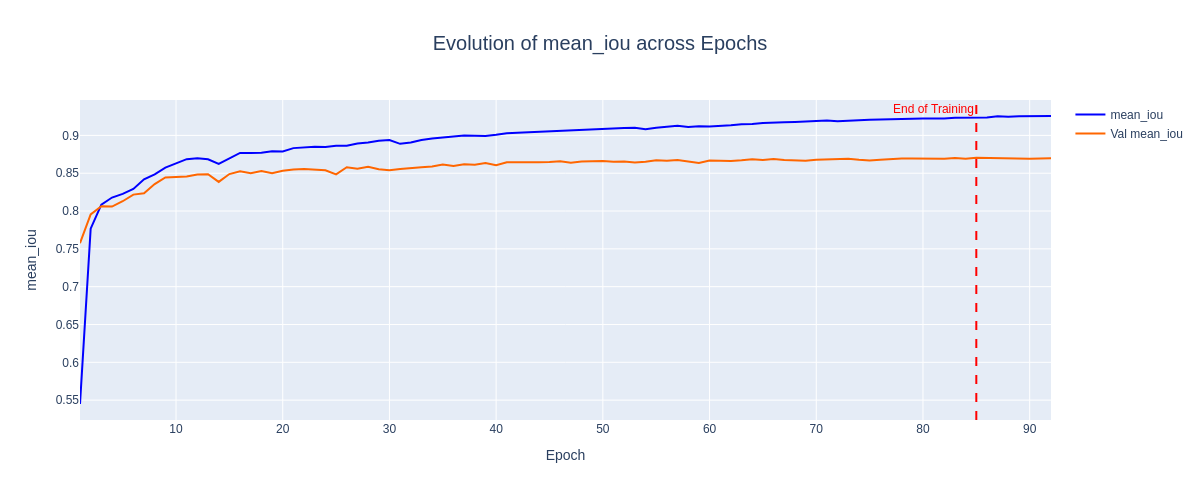

In [ ]:
# Static image for GitHub
plot_metrics(history, metrics=["loss", "accuracy", "mean_iou"], renderer="png")

### **Mean IoU and Dice Score**

In [17]:
# Load the fine-tuned model
tf.keras.backend.clear_session()

with strategy.scope():
  model = TFAutoModelForSemanticSegmentation.from_pretrained(trained_model_path)

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at /content/drive/MyDrive/models/SemanticSegmentation_SegFormer-B2_CamVid.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [18]:
# Instantiate the segmentation metrics
mean_iou = SegmentationMetrics(
    metric_name="mean_iou",
    num_classes=num_classes,
    image_size=image_size,
    ignore_class=ignore_class
)

dice_score = SegmentationMetrics(
    metric_name="dice_score",
    num_classes=num_classes,
    image_size=image_size,
    ignore_class=ignore_class
)

# TensorFlow Mean IoU Metric
mean_iou_tf = tf.keras.metrics.MeanIoU(
    num_classes=num_classes,
    ignore_class=ignore_class,
    sparse_y_true=True,
    sparse_y_pred=True
)

#### **Validation Dataset**

In [19]:
# Extract the components of the validation dataset and make predictions
val_dataset = prepare_dataset(
    df_val,
    train=False,
    drop_remainder=False
)

images_val = val_dataset.unbatch().map(lambda x, y: x)
images_val = np.array(list(images_val.as_numpy_iterator()))

masks_val = val_dataset.unbatch().map(lambda x, y: y)
masks_val = np.array(list(masks_val.as_numpy_iterator()))

masks_val_pred = model.predict(val_dataset).logits
masks_val_pred = tf.transpose(masks_val_pred, [0, 2, 3, 1])
masks_val_pred = tf.image.resize(masks_val_pred, image_size[:-1])
masks_val_pred = np.argmax(masks_val_pred, axis=-1)

18/18 [==============================] - 56s 541ms/step


In [20]:
# Update the metrics
for i in tqdm(range(0, len(masks_val), batch_size)):
  batch_true = masks_val[i: i + batch_size]
  batch_pred = masks_val_pred[i: i + batch_size]

  dice_score.update_state(batch_true, batch_pred, preprocess=False)
  mean_iou.update_state(batch_true, batch_pred, preprocess=False)
  mean_iou_tf.update_state(batch_true, batch_pred)

  0%|          | 0/18 [00:00<?, ?it/s]

In [21]:
# Create a DataFrame with the metrics for each class
df_val = pd.DataFrame({
    "Class": class_names,
    "IoU": mean_iou.result_by_class(),
    "Dice Score": dice_score.result_by_class()
})
df_val

Class       IoU  Dice Score
0         void       NaN         NaN
1          sky  0.933930    0.965836
2     building  0.938678    0.968369
3         pole  0.634843    0.776641
4         road  0.983442    0.991652
5     sidewalk  0.917363    0.956901
6         tree  0.860465    0.925000
7   signsymbol  0.807390    0.893432
8        fence  0.864377    0.927255
9          car  0.937919    0.967965
10  pedestrian  0.805419    0.892224
11   bicyclist  0.873156    0.932283

In [22]:
# Remove empty records
df_val = df_val.dropna()

# Calculate the average of the metrics
df_val.IoU.mean(), mean_iou_tf.result().numpy(), df_val["Dice Score"].mean()

(0.86881673, 0.86881673, 0.92705095)

It can be seen that the results of the custom **Mean IoU** metric and the **TensorFlow** metric match on both the training and test dataset, which helps verify and confirm that the custom metric is correctly implemented. However, the custom metric is superior as it not only calculates the **Mean IoU** but also the **Dice Score**. Additionally, it offers the option to calculate the **Mean IoU** both globally and per class, a feature that the **TensorFlow** metric does not provide.

## **Inference with the Trained Model**

### **Validation Dataset**

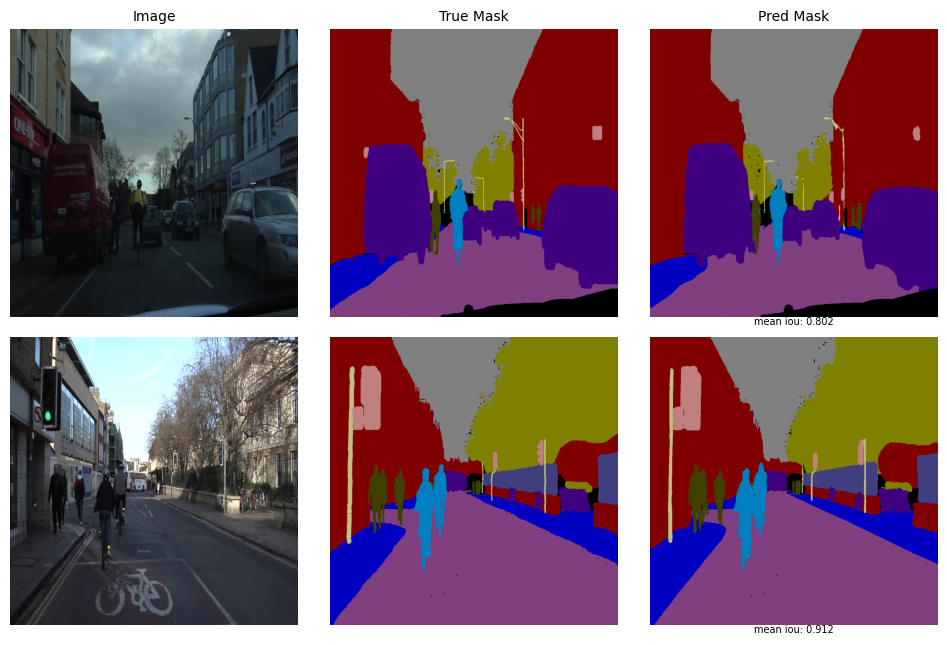

In [28]:
plot_image_masks(images_val, masks_val, masks_val_pred, n_rows=2, random=False, metric=mean_iou)

 The following example shows the results of the custom Mean IoU metric by class, highlighting the importance of not considering absent classes in the real and predicted segmentation masks. The average result matches TensorFlow's Mean IoU metric. Adding a very small epsilon value to both the numerator and denominator when calculating the Mean IoU or Dice Score to prevent division by zero could lead to incorrect results when classes are missing. If the real mask lacks certain classes and the model correctly predicts only the present classes, adding epsilon for absent classes would result in a value of 1 (perfect score), which would skew the average to an incorrect value. Similarly, adding a value of 0 for absent classes would also yield an incorrect and lower average. Therefore, it is important to assign a NaN value to absent classes in the real masks only if they are also absent in the predicted masks and to average the results only for classes with non-NaN values.

In [26]:
# Calculation of the Mean IoU for the first image in the above mosaic
id = 0
mean_iou.reset_state()
mean_iou_tf.reset_state()

mean_iou.update_state(masks_val[id], masks_val_pred[id], preprocess=False)
mean_iou_tf.update_state(masks_val[id], masks_val_pred[id])

print(pd.DataFrame({"class": class_names, "IoU": mean_iou.result_by_class()}), "\n")
print(mean_iou.result().numpy(), mean_iou_tf.result().numpy())

         class       IoU
0         void       NaN
1          sky  0.954659
2     building  0.973560
3         pole  0.439642
4         road  0.953284
5     sidewalk  0.803595
6         tree  0.749444
7   signsymbol  0.546650
8        fence       NaN
9          car  0.951795
10  pedestrian  0.724351
11   bicyclist  0.920121 

0.80171 0.80171


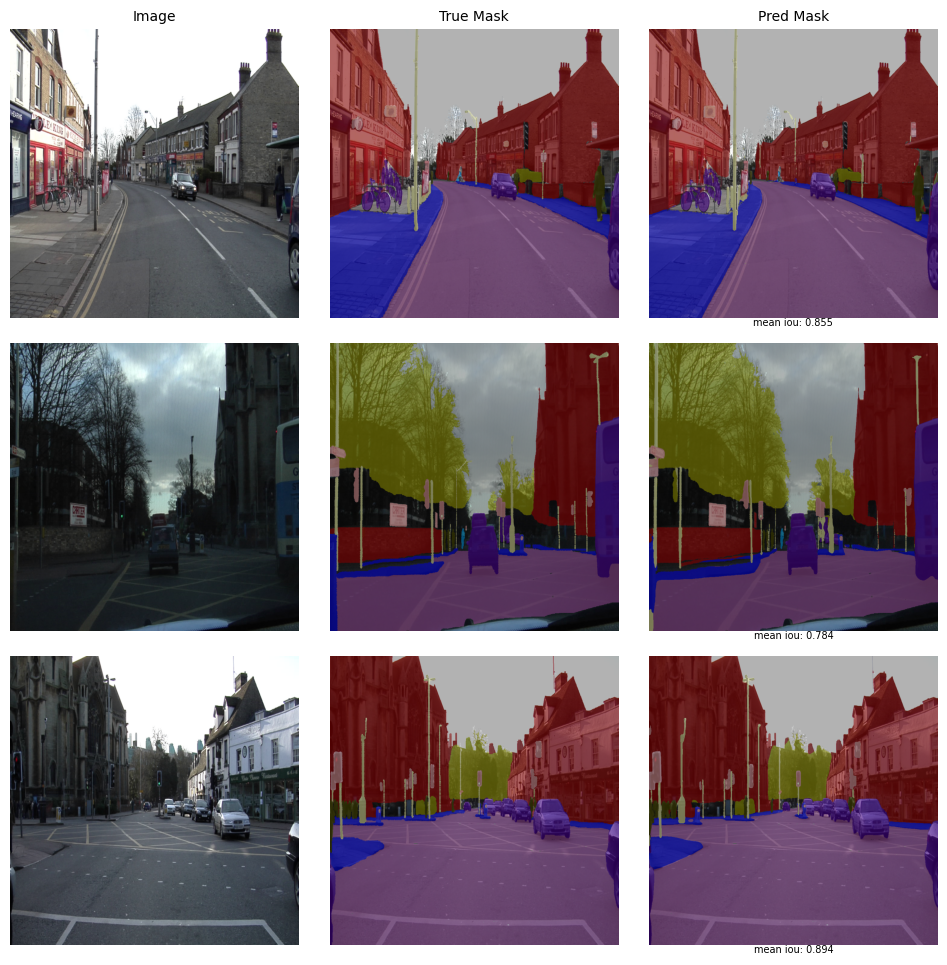

In [32]:
plot_image_masks(images_val, masks_val, masks_val_pred, blended=True, metric=mean_iou)

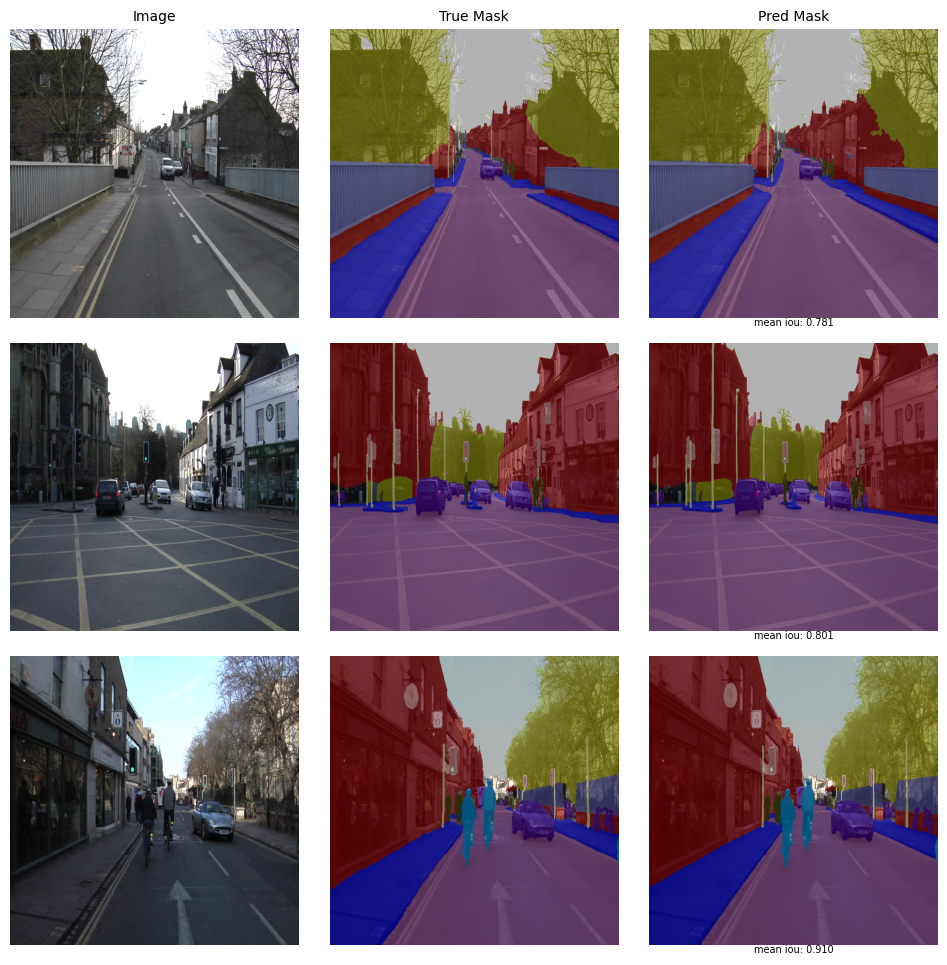

In [45]:
plot_image_masks(images_val, masks_val, masks_val_pred, blended=True, metric=mean_iou)

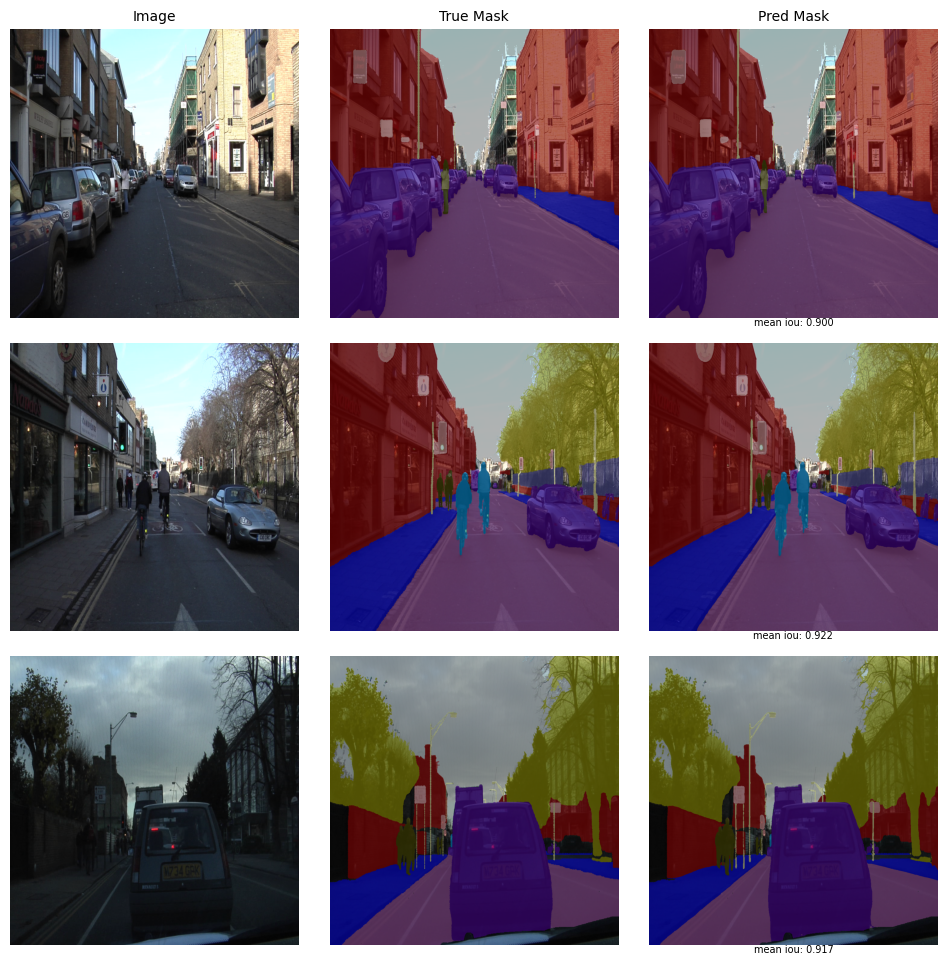

In [61]:
plot_image_masks(
    images_val, masks_val, masks_val_pred,
    blended=True, metric=mean_iou, save=True,
    path_save="SemanticSegmentation_SegFormer-B2_CamVid.png"
)

## **Conclusion**

The **fine-tuned SegFormer-B2** model has demonstrated strong performance in semantic segmentation on the **CamVid** dataset, achieving a **Mean IoU** of **0.9248** on the training set, a **Mean IoU** of **0.8688**, and a **Dice Score** of **0.9271** on the validation set. These results highlight the effectiveness of the implemented strategies, such as the combined **cross-entropy** and **dice loss** with weights for the more challenging and less frequent classes, **data augmentation** to mitigate overfitting, and a custom optimizer from the Transformers library, enabling gradual and efficient training. The use of the **early stopping** callback prevented overtraining, achieving a proper balance between training accuracy and generalization. Some overfitting is observed, which is reasonable given the small size of the training dataset.

Class-wise analysis shows that the model segments excellently in 8 classes, all of which have an IoU greater than 86%, while performing moderately on the `signsymbol` and `pedestrian` classes, which have an IoU slightly above 80%, and poorly on the `pole` class due to its lower presence and complexity, with an IoU just over 63%. It is worth noting that without applying class weights to the loss for these 3 classes, the `signsymbol` and `pedestrian` classes would have had an IoU below 80%, and the IoU for the `pole` class would have been even lower, underscoring the importance of these weights for achieving better results.

The model performs well on the **CamVid** dataset, but on more modern, complex, and varied images, its performance is moderate. To achieve better results and have a more robust model that generalizes better to urban street images for autonomous driving, it would be suitable, for example, to add more images and segmentation masks to the training dataset or use a larger dataset, such as **Cityscapes**, for model fine-tuning. However, better computing resources than the free Colab TPU would be necessary. For educational and demonstrative purposes, this fine-tuned model is excellent for segmenting the CamVid dataset.